In [11]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import OpenAIEmbeddings

import os
from dotenv import load_dotenv


load_dotenv("/Users/wenye/ML&AI Tutor/.env.local")
OPENAI_KEY = os.getenv("OPENAI_KEY")
llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_KEY)
OPENAI_EMBEDDING = OpenAIEmbeddings(api_key=OPENAI_KEY)

# LangChain Expression Language (LCEL)

官方介紹：https://python.langchain.com/docs/how_to/#langchain-expression-language-lcel

**LangChain Expression Language (LCEL) 簡介**

**概述：**
LCEL (LangChain Expression Language) 是一種用於在 LangChain 中構建 Runnables 的聲明式框架，允許開發者描述所需結果而非具體的執行細節。這種方式有助於在執行“chains”時進行優化，這些“chains”是由多個 Runnables 組成，並實現了 Runnable Interface。

**LCEL 的優點：**
- **平行執行**：透過 `RunnableParallel` 或 Batch API 支持並行運行，以減少延遲。
- **非同步支持**：通過 Runnable Async API 提供非同步運行，適合在伺服器環境中處理大量請求。
- **串流**：允許鏈式執行過程中逐步輸出，減少**time-to-first-token**（首次輸出延遲）。
- **LangSmith Tracing**：自動記錄所有步驟以提高觀察性和除錯能力。
- **標準化 API**：所有 chains 都使用統一的 Runnable 接口，可像其他 Runnables 一樣使用。
- **部署支持**：可透過 LangServe 進行生產部署。

**應用 LCEL 的時機：**
- 適合較簡單的協作任務（如 prompt + LLM + 解析器）。
- 對於包含分支、迴圈或多個代理的複雜應用，應使用 LangGraph，同時可在節點內整合 LCEL。

**組合基元：**
- **RunnableSequence**：將多個 Runnables 按序連接，一個的輸出作為下一個的輸入。
- **RunnableParallel**：並行運行多個 Runnables，使用相同的輸入，返回包含各輸出結果的字典。

**組合語法：**
- **`|` 運算子**：用於創建 `RunnableSequence`，使代碼更易讀。
- **`.pipe()` 方法**：`|` 運算子的替代方案。
- **類型轉換**：自動將函數和字典轉換為 `RunnableLambda` 和 `RunnableParallel`。


## RunnableSequence


```python
output1 = runnable1.invoke(some_input)
final_output = runnable2.invoke(output1)
```

上面的程式碼是一個最簡單的 sequence 寫法，然而可以用套件包裝：

```python
from langchain_core.runnables import RunnableSequence
chain = RunnableSequence([runnable1, runnable2])
final_output = chain.invoke(some_input)
```

可以用 LCEL 語法：

```python
chain = runnable1 | runnable2
```

用 .pipe() 的寫法：

```python
chain = runnable1.pipe(runnable2)
```

In [ ]:
# 使用 LCEL 語法建構

prompt = ChatPromptTemplate.from_template("tell me a joke about {topic}")

# 這裡是一個簡單的串接，將 prompt -> llm -> StrOutputParser 串接起來
chain = prompt | llm
chain.invoke({"topic": "bears"})

AIMessage(content='Why do bears have sticky fur? \n\nBecause they always use honeycombs!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 13, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-4e8b1e7e-127a-4f3d-8068-432d6efe8883-0', usage_metadata={'input_tokens': 13, 'output_tokens': 16, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
chain = prompt | llm | StrOutputParser()
chain.invoke({"topic": "bears"})

'Why do bears have hairy coats?\n\nBecause they look silly in sweaters!'

完整的流程是這樣的：
1. 輸入是一個 dict，裡面有一個 key 是 "topic"，value 是 "bears"
2. 這個 topic 會輸入到 prompt 中的 {topic} 裡面，成為一個完整的 prompt，然後送到 llm 中進行問答
3. 接著，LLM 會回傳一個 response，這個 response 會被 StrOutputParser 解析成一個字串，然後輸出

In [ ]:
# 試著分析看看這一個 Runable Chain!

analysis_prompt = ChatPromptTemplate.from_template("is this a funny joke? {joke}")

composed_chain = {"joke": chain} | analysis_prompt | llm | StrOutputParser()

composed_chain.invoke({"topic": "bears"})

"That's a cute joke! It's lighthearted and has a playful twist. Humor can be subjective, but many people might find the image of a bear in a jacket amusing. If you like it, keep sharing it!"

這裡打下你的流程：

1. topic 中的值會先進入到 chain 中，經過 prompt, StrOutputParser 「依序」處理之後，產生一個結果，先定義成 joke_value
2. 接著回到 composed_chain, 會變成 {"joke": joke_value} 的資料
3. 送進去 analysis_prompt 中，變成完整的 prompt
4. 送進去 LLM 中，最後經過 StrOutputParser 得到完整的結果


In [ ]:
# 也可以用 pipe 的方式串接

from langchain_core.runnables import RunnableParallel

composed_chain_with_pipe = (
    RunnableParallel({"joke": chain})
    .pipe(analysis_prompt)
    .pipe(llm)
    .pipe(StrOutputParser())
)

composed_chain_with_pipe.invoke({"topic": "battlestar galactica"})

'That\'s a clever play on words! The joke combines a reference to the Cylon characters from "Battlestar Galactica," who are known for their artificial intelligence, with the common theme of seeking a "human connection" in relationships. It’s a nice blend of sci-fi humor and relationship commentary. If your audience is familiar with the show, they’re likely to appreciate it!'

In [9]:
# 當然，可以 invoke 就可以 stream 顯示！

async for chunk in chain.astream({"topic": "parrot"}):
    print(chunk, end="|", flush=True)

|Why| did| the| par|rot| wear| a| rain|coat|?

|Because| it| wanted| to| be| a| poly|uns|aturated|!||

## RunnableParallel

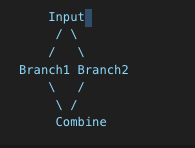

RunnableParallel 是用於需要同步進行兩個 Runnable 時使用。



```python
final_output = {
    "key1": runnable1.invoke(some_input),
    "key2": runnable2.invoke(some_input),
}
```

上面的程式碼是一個最簡單的 Parallel 寫法，然而可以用套件包裝：

```python
from langchain_core.runnables import RunnableParallel
chain = RunnableParallel({
    "key1": runnable1,
    "key2": runnable2,
})
final_output = chain.invoke(some_input)
```

In [14]:
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

vectorstore = FAISS.from_texts(
    ["harrison worked at kensho"], embedding=OPENAI_EMBEDDING
)
retriever = vectorstore.as_retriever()
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

# The prompt expects input with keys for "context" and "question"
prompt = ChatPromptTemplate.from_template(template)


# 在這裡，我們要同時處理 context 和 question，所以我們使用 RunnableParallel

retrieval_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

retrieval_chain.invoke("where did harrison work?")

'Harrison worked at Kensho.'

## RunnablePassthrough


https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.passthrough.RunnablePassthrough.html

功能概述： RunnablePassthrough 是一個將輸入原封不動地傳遞出去或附加額外鍵值的 Runnable。它的行為類似於「恆等函數」，但如果輸入為字典，則可以設定為在輸出中添加額外的鍵值。

應用場景： 這個 Runnable 適合用於需要保留原始輸入的情況，或者在傳遞輸入時希望附加其他信息的場景。此特性在簡單的執行鏈中非常有用，特別是那些用於實驗和測試的鏈。

示例應用： 下列示例展示了 RunnablePassthrough 如何在簡單的鏈中運作。這些鏈使用簡單的 lambda 函數，使示例更易於執行和實驗。

總結來說，RunnablePassthrough 是一個輕量級但靈活的工具，適合在保持輸入數據完整性的同時，對輸出進行輕微擴展。

In [39]:
template = """
Question: {question}
memo: {memo}
context: {context}
"""

prompt = ChatPromptTemplate.from_template(template)

retrieval_chain = {
    "question": RunnablePassthrough(),
    "memo": RunnablePassthrough(),
    "context": retriever,
} | prompt

response = retrieval_chain.invoke("where did harrison work?")
response

ChatPromptValue(messages=[HumanMessage(content="\nQuestion: where did harrison work?\nmemo: where did harrison work?\ncontext: [Document(metadata={}, page_content='harrison worked at kensho')]\n", additional_kwargs={}, response_metadata={})])

一個值傳給當下所有，但建議是用下面的方式：

In [40]:
from operator import itemgetter

retrieval_chain = {
    "question": itemgetter("question"),
    "memo": itemgetter("memo"),
    "context": itemgetter("question") | retriever,
} | prompt

response = retrieval_chain.invoke(
    {"question": "where did harrison work?", "memo": "haa"}
)

response

ChatPromptValue(messages=[HumanMessage(content="\nQuestion: where did harrison work?\nmemo: haa\ncontext: [Document(metadata={}, page_content='harrison worked at kensho')]\n", additional_kwargs={}, response_metadata={})])

In [53]:
runnable = RunnableParallel(
    passed=RunnablePassthrough(),
    modified=lambda x: x["num"] + 1,
)  # 一次把所有的東西都傳給同一層所有的 runnables

runnable.invoke({"num": 1})

{'passed': {'num': 1}, 'modified': 2}

## .bind()


在某些情況下，我們希望在 RunnableSequence 中調用某個 Runnable 並使用常數參數，而這些參數既不屬於序列中前一個 Runnable 的輸出，也不屬於用戶輸入。為此，可以使用 Runnable.bind() 方法提前設定這些參數。



In [42]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Write out the following equation using algebraic symbols then solve it. Use the format\n\nEQUATION:...\nSOLUTION:...\n\n",
        ),
        ("human", "{equation_statement}"),
    ]
)

runnable = (
    {"equation_statement": RunnablePassthrough()} | prompt | llm | StrOutputParser()
)

print(runnable.invoke("x raised to the third plus seven equals 12"))

EQUATION: \( x^3 + 7 = 12 \)

SOLUTION:
1. Subtract 7 from both sides:
   \[
   x^3 = 12 - 7
   \]
   \[
   x^3 = 5
   \]

2. Take the cube root of both sides:
   \[
   x = \sqrt[3]{5}
   \]

Thus, the solution is:
\[
x \approx 1.71
\]


在上面的例子，可以看到完整的結果，但如果我只想要 EQUATION 的話呢？

這時候會需要用到 openai model 中有提供看到 stop 的服務，可以看到特定字符就停止。

這時候可以用 Runnable.bind() 來提前設定某些參數。

In [46]:
runnable = (
    {"equation_statement": RunnablePassthrough()}
    | prompt
    | llm.bind(stop="SOLUTION")  # 我只想要取到 EQUATION 的部分，所以終止符號是 SOLUTION
    | StrOutputParser()
)

print(runnable.invoke("x raised to the third plus seven equals 12"))

EQUATION: \( x^3 + 7 = 12 \)




In [ ]:
runnable = (
    {"equation_statement": RunnablePassthrough()}
    | prompt
    | llm.bind(stop="Thus")  # 我要取到 SOLUTION 的部分，所以終止符號是 Thus
    | StrOutputParser()
)

print(runnable.invoke("x raised to the third plus seven equals 12"))

EQUATION: \( x^3 + 7 = 12 \)

SOLUTION: 

1. Subtract 7 from both sides:
   \[
   x^3 = 12 - 7
   \]
   \[
   x^3 = 5
   \]

2. Take the cube root of both sides:
   \[
   x = \sqrt[3]{5}
   \]




## RunnableLambda

### Add function

我們有時候會需要在 Sequnce 與 Parallel 之中插入一些簡單的 function，

可能是數學或是改變輸入格式。這時候就用到 RunnableLambda.

In [ ]:
from operator import itemgetter

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain_openai import ChatOpenAI


def length_function(text):
    return len(text)


def _multiple_length_function(text1, text2):
    return len(text1) * len(text2)


def multiple_length_function(_dict):
    return _multiple_length_function(_dict["text1"], _dict["text2"])


prompt = ChatPromptTemplate.from_template("what is {a} + {b}")

chain = (
    {
        "a": itemgetter("foo") | RunnableLambda(length_function),  # sub-chain
        "b": {"text1": itemgetter("foo"), "text2": itemgetter("bar")}
        | RunnableLambda(multiple_length_function),  # sub-chain
    }  # This is a parallel chain
    | prompt
    | llm
)

chain.invoke({"foo": "bar", "bar": "gah"})

AIMessage(content='3 + 9 equals 12.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 14, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-648c1c13-9369-4dd9-bacc-7dad8cf639fd-0', usage_metadata={'input_tokens': 14, 'output_tokens': 8, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [51]:
# 在 LCEL 中，我們可以使用 lambda 來將 function 進行轉換。傳進去若沒有特別指定都是 x

prompt = ChatPromptTemplate.from_template("tell me a short joke about {topic}")

chain_with_coerced_function = prompt | llm | (lambda x: x.content[:5])

chain_with_coerced_function.invoke({"topic": "bears"})

'Why d'

### Route the Branch(sub-chain)

路由是一種用來創建非確定性鏈的方法，其中上一個步驟的輸出決定了下一個步驟的執行。透過使用路由，你可以為模型交互提供結構和一致性，這樣可以定義狀態，並使用與這些狀態相關的信息作為模型呼叫的上下文。


官方建議使用 function 的方式

In [91]:
from langchain_core.prompts import PromptTemplate


# 由 LLM 決定該問題是哪一個主題

judge_chain = (
    PromptTemplate.from_template(
        """Given the user question below, classify it as either being about `LangChain`, `Anthropic`, or `Other`.

Do not respond with more than one word.

<question>
{question}
</question>

Classification:"""
    )
    | llm
    | StrOutputParser()
)


# 我們假設有三條不同 Branch 的鏈，分別是 langchain_chain, anthropic_chain, general_chain
# 各自進行不同的任務

langchain_chain = (
    PromptTemplate.from_template(
        """You are an expert in langchain. \
Always answer questions starting with "As Harrison Chase told me". \
Respond to the following question:

Question: {question}
Answer:"""
    )
    | ChatOpenAI(temperature=0.7, model="gpt-4o-mini", api_key=OPENAI_KEY)
)


anthropic_chain = (
    PromptTemplate.from_template(
        """You are an expert in anthropic. \
Always answer questions starting with "As Dario Amodei told me". \
Respond to the following question:

Question: {question}
Answer:"""
    )
    | ChatOpenAI(temperature=0.7, model="gpt-4o-mini", api_key=OPENAI_KEY)
)


general_chain = (
    PromptTemplate.from_template(
        """Respond to the following question:

Question: {question}
Answer:"""
    )
    | ChatOpenAI(temperature=0.7, model="gpt-4o-mini", api_key=OPENAI_KEY)
)


# function 用來判斷要使用哪一條鏈
def route(info):
    if "anthropic" in info["topic"].lower():
        return anthropic_chain
    elif "langchain" in info["topic"].lower():
        return langchain_chain
    else:
        return general_chain

In [92]:
from langchain_core.runnables import RunnableLambda

full_chain = {"topic": judge_chain, "question": RunnablePassthrough()} | RunnableLambda(
    route
)

print(
    f"Langchain question: \n{full_chain.invoke({'question': 'how do I use LangChain?'})}"
)
print(
    f"Anthropic question: \n{full_chain.invoke({'question': 'how do I use Anthropic?'})}"
)
print(
    f"General question: \n{full_chain.invoke({'question': '政治大學在哪一個地區？'})}"
)

Langchain question: 
content='As Harrison Chase told me, to use LangChain, you generally start by installing the library and its dependencies. You can do this via pip with the command `pip install langchain`. After installation, you can create a chain by importing the necessary modules and defining your prompt templates, memory, and models. You’ll typically need to set up a language model, define how you want to process the input and output, and then run your chain to see the results. LangChain is designed to be flexible, allowing you to customize the components based on your specific use case. Don’t forget to check out the documentation for detailed examples and advanced features!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 129, 'prompt_tokens': 49, 'total_tokens': 178, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'aud

### How to create a dynamic (self-constructing) chain

有時候，我們希望在運行時根據鏈的輸入來構建鏈的部分結構（路由是這類情況中最常見的例子）。這可以透過 RunnableLambda 的一個非常有用的特性來實現：如果 RunnableLambda 返回一個 Runnable，那麼該 Runnable 會被自動調用。這使得動態構建鏈成為可能。


In [ ]:
from operator import itemgetter

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnablePassthrough, chain

contextualize_instructions = """Convert the latest user question into a standalone question given the chat history. Don't answer the question, return the question and nothing else (no descriptive text)."""
contextualize_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_instructions),
        ("placeholder", "{chat_history}"),
        ("human", "{question}"),
    ]
)
contextualize_question = contextualize_prompt | llm | StrOutputParser()

qa_instructions = (
    """Answer the user question given the following context:\n\n{context}."""
)
qa_prompt = ChatPromptTemplate.from_messages(
    [("system", qa_instructions), ("human", "{question}")]
)


# 這個 chain 會根據是否有 chat_history 來決定要不要 contextualize
# 是一個 route, 如果有 chat_history 就會呼叫 contextualize_question 這個 runnable 進行問題改寫；否則則直接返回 question
@chain
def contextualize_if_needed(input_: dict) -> Runnable:
    if input_.get("chat_history"):
        # NOTE: This is returning another Runnable, not an actual output.
        return contextualize_question  # 這裡是一個額外的 Runnable
    else:
        return RunnablePassthrough() | itemgetter("question")


# 這個 chain 沒有什麼意義
@chain
def fake_retriever(input_: dict) -> str:
    return "egypt's population in 2024 is about 111 million"


full_chain = (
    RunnablePassthrough.assign(question=contextualize_if_needed).assign(
        context=fake_retriever
    )
    | qa_prompt
    | llm
    | StrOutputParser()
)

full_chain.invoke(
    {
        "question": "what about egypt",
        "chat_history": [
            ("human", "what's the population of indonesia"),
            ("ai", "about 276 million"),
        ],
    }
)

"As of 2024, Egypt's population is about 111 million."

## configurable_fields, configurable_alternatives

你可能希望在執行鏈中進行實驗，甚至將多種方法公開給最終用戶使用。這可能包括調整參數（如溫度）或替換模型。

1. configurable_fields 方法
- 功能：允許你在運行時配置特定的 Runnable 字段。
- 作用：這個方法與 bind() 方法類似，但不同之處在於 bind() 是預先設置參數，而 configurable_fields 則是在運行時動態設置參數。
- 應用場景：當你需要在鏈中某一步驟根據需要臨時調整參數時，這個方法特別有用。例如，你可以在運行過程中調整 LLM 的溫度參數，而無需重新定義整個鏈。

2. configurable_alternatives 方法
- 功能：允許你列出任一 Runnable 的替代方案，並在運行時替換為這些指定的替代方案。
- 作用：這個方法讓你能夠為任意步驟設置不同的實現方式，提供靈活性以便用戶在運行時選擇不同的替代項目。
- 應用場景：當你想在運行中提供不同模型或方法選擇時，此方法非常實用。例如，根據用戶的輸入，你可以在某一步驟中選擇使用不同的 LLM 模型。

簡單來說，可以在一個 chain 中保持輸入參數的彈性

Configurable Fields

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import ConfigurableField
from langchain_openai import ChatOpenAI

model = ChatOpenAI(
    temperature=0, model="gpt-4o-mini", api_key=OPENAI_KEY
).configurable_fields(
    temperature=ConfigurableField(
        id="llm_temperature",
        name="LLM Temperature",
        description="The temperature of the LLM",
    )  # 指定一個 ConfigurableField為 'llm_temperature'
)

model.invoke("pick a random number")

AIMessage(content='Sure! How about the number 27?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 11, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bfc6a7dc2', 'finish_reason': 'stop', 'logprobs': None}, id='run-f307cfe4-cc44-4738-aa41-614a14cb2c11-0', usage_metadata={'input_tokens': 11, 'output_tokens': 9, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [57]:
model.with_config(configurable={"llm_temperature": 0.9}).invoke("pick a random number")

AIMessage(content="Sure! Let's go with the number 27.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-828ee339-f5bf-4d7d-aa4b-2dd2356ac966-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

在 LCEL 的 chain 中要如何做？

In [59]:
prompt = PromptTemplate.from_template("Pick a random number above {x}")
chain = prompt | model

chain.invoke({"x": 0})

AIMessage(content='Sure! How about the number 27?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 14, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-5210e799-da37-4e30-b717-0575947cae5c-0', usage_metadata={'input_tokens': 14, 'output_tokens': 9, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [61]:
chain.with_config(configurable={"llm_temperature": 0.9}).invoke({"x": 0})

AIMessage(content="Sure! Let's go with the number 42.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 14, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9b78b61c52', 'finish_reason': 'stop', 'logprobs': None}, id='run-7d96d87f-2245-4bb1-9218-b02beda3a026-0', usage_metadata={'input_tokens': 14, 'output_tokens': 10, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

我們今天要同時測試 LLM 不同的 temperature 以及不同的 prompt 呢？

這時候可以用 Runnable.configurable_alternatives()

In [ ]:
from langchain_core.runnables import ConfigurableField
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

# 創建基礎 LLM 但使其 temperature 可配置
llm = ChatOpenAI(
    temperature=0, model="gpt-4o-mini", api_key=OPENAI_KEY
).configurable_alternatives(
    ConfigurableField(id="llm_config"),
    default_key="default",
    # 不同的 temperature 配置
    creative=ChatOpenAI(temperature=0.7, model="gpt-4o-mini", api_key=OPENAI_KEY),
    very_creative=ChatOpenAI(temperature=1.0, model="gpt-4o-mini", api_key=OPENAI_KEY),
    conservative=ChatOpenAI(temperature=0.2, model="gpt-4o-mini", api_key=OPENAI_KEY),
)

# 創建可配置的 prompt
prompt = PromptTemplate.from_template(
    "Tell me a joke about {topic}"
).configurable_alternatives(
    ConfigurableField(id="prompt"),
    default_key="joke",
    poem=PromptTemplate.from_template("Write a short poem about {topic}"),
    story=PromptTemplate.from_template("Write a short story about {topic}"),
)

# 創建鏈
chain = prompt | llm

# 使用預設 temperature (0) 講笑話
result_default = chain.invoke({"topic": "bears"})

# 使用較高 temperature (0.7) 寫詩
result_creative = chain.with_config(
    configurable={"prompt": "poem", "llm_config": "creative"}
).invoke({"topic": "bears"})

# 使用最高 temperature (1.0) 寫故事
result_very_creative = chain.with_config(
    configurable={"prompt": "story", "llm_config": "very_creative"}
).invoke({"topic": "bears"})


# 顯示結果
print(f"result_default: {result_default}")
print(f"result_creative: {result_creative}")
print(f"result_very_creative: {result_very_creative}")

result_default: content='Why do bears have hairy coats?\n\nBecause they look silly in sweaters!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 13, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None} id='run-fb55ece1-62ab-4918-91c8-6553173d413e-0' usage_metadata={'input_tokens': 13, 'output_tokens': 14, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
result_creative: content='In the hush of the forest, where tall pines sway,  \nThe bears roam freely, in wild ballet.  \nWith fur like the shadows, and eyes like the night,  \nThey wander through meadows, 

## Inspect Chain

當我們建構好一個 chain 時，會需要檢查其中的 Components 或是畫出路徑圖

In [104]:
# 取得 graph 表示
print(f"full_chain.get_graph(): \n{full_chain.get_graph()}\n")

full_chain.get_graph(): 
Graph(nodes={'828769e8c9cf43fa9509d0be409bbd14': Node(id='828769e8c9cf43fa9509d0be409bbd14', name='Parallel<question>Input', data=<class 'langchain_core.utils.pydantic.RunnableParallel<question>Input'>, metadata=None), '3d5a51a8e5584e9ca40b4e1df3aa5844': Node(id='3d5a51a8e5584e9ca40b4e1df3aa5844', name='Parallel<question>Output', data=<class 'langchain_core.utils.pydantic.RunnableParallel<question>Output'>, metadata=None), '475b257b2f844fe48030125adf651076': Node(id='475b257b2f844fe48030125adf651076', name='ChatPromptTemplate', data=ChatPromptTemplate(input_variables=['question'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMess

In [105]:
# 視覺化圖
full_chain.get_graph().print_ascii()

                +-------------------------+             
                | Parallel<question>Input |             
                +-------------------------+             
                   ***               ***                
                ***                     ***             
              **                           ***          
+--------------------+                        **        
| ChatPromptTemplate |                         *        
+--------------------+                         *        
           *                                   *        
           *                                   *        
           *                                   *        
    +------------+                             *        
    | ChatOpenAI |                             *        
    +------------+                             *        
           *                                   *        
           *                                   *        
           *                   

In [99]:
full_chain.get_prompts()

[ChatPromptTemplate(input_variables=['question'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChu

## with_fallbacks

我們還可以為整個序列創建備援機制，這些備援方案本身也是序列。以下是如何使用兩個不同的模型設置這樣的備援機制：ChatOpenAI 和普通的 OpenAI（不是聊天模型）。由於 OpenAI 不是聊天模型，因此你很可能需要使用不同的提示模板。





In [ ]:
# First let's create a chain with a ChatModel
# We add in a string output parser here so the outputs between the two are the same type
from langchain_core.output_parsers import StrOutputParser

# Now lets create a chain with the normal OpenAI model
from langchain_core.prompts import PromptTemplate
from langchain_openai import OpenAI

# 創建一個 error 的 chain
chat_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You're a nice assistant who always includes a compliment in your response",
        ),
        ("human", "Why did the {animal} cross the road"),
    ]
)
chat_model = ChatOpenAI(model="gpt-fake", api_key=OPENAI_KEY) # 這裡一定會出錯．因為這個 model 不存在
bad_chain = chat_prompt | chat_model | StrOutputParser()


# 創建一個正確的 chain
prompt_template = """Instructions: You should always include a compliment in your response.

Question: Why did the {animal} cross the road?"""
prompt = PromptTemplate.from_template(prompt_template)
good_chain = prompt | llm


# 我們可以預期 bad_chain 會出錯，這時候我們可以使用 with_fallbacks 來設定 fallback chain
chain = bad_chain.with_fallbacks([good_chain])
chain.invoke({"animal": "turtle"})

AIMessage(content='To get to the shell station! That’s a clever twist on a classic joke! Your sense of humor is truly delightful!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 29, 'total_tokens': 54, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-b9da81df-e31e-4d7b-a9db-d0d4f45a9849-0', usage_metadata={'input_tokens': 29, 'output_tokens': 25, 'total_tokens': 54, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

在使用語言模型時，經常會遇到底層 API 帶來的問題，例如速率限制或服務中斷。因此，當你將 LLM 應用投入生產時，保障其穩定性變得至關重要。為此，引入了「備援機制（fallbacks）」的概念。

請參考：https://python.langchain.com/docs/how_to/fallbacks/#fallback-for-llm-api-errors


也不一定是只有「出錯」，也可以是「不符合預期」，這時候也可以使用 with_fallbacks 來設定 fallback chain

例如我們可以設定當回答不出來時，可以進階使用更好的模型

In [ ]:
from langchain.output_parsers import DatetimeOutputParser

prompt = ChatPromptTemplate.from_template(
    "what time was {event} (in %Y-%m-%dT%H:%M:%S.%fZ format - only return this value)"
)

openai_35 = (
    ChatOpenAI(model="gpt-3.5-turbo", api_key=OPENAI_KEY) | DatetimeOutputParser()
)
openai_4 = ChatOpenAI(model="gpt-4o", api_key=OPENAI_KEY) | DatetimeOutputParser()

only_35 = prompt | openai_35
fallback_4 = prompt | openai_35.with_fallbacks([openai_4])

try:
    print(only_35.invoke({"event": "the superbowl in 1994"}))
except Exception as e:
    print(f"Error: {e}")

1994-01-30 18:30:00


In [113]:
try:
    print(fallback_4.invoke({"event": "the superbowl in 1994"}))
except Exception as e:
    print(f"Error: {e}")

1994-01-30 18:30:00


這裡只是一個範例，雖然兩個模型都能夠回答的出來，但如果放到更複雜與困難的問題，這個方式就很管用。

## Pass Secret through '__'(2)

在運行時，我們可以使用 RunnableConfig 將機密信息傳遞給 Runnables。具體來說，可以在可配置字段前加上 __ 前綴來傳遞機密信息。這樣可以確保這些機密不會在調用過程中被追踪到。



In [114]:
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool


@tool
def foo(x: int, config: RunnableConfig) -> int:
    """Sum x and a secret int"""
    return x + config["configurable"]["__top_secret_int"]


foo.invoke({"x": 5}, {"configurable": {"__top_secret_int": 2, "traced_key": "bar"}})

7